# New classification: Sequential Model

In [27]:
import numpy as np
import pandas as pd 
import os
import itertools
import os
import re

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
layers = keras.layers
models = keras.models

# fetch data

In [28]:
path = "data/20news-18828"
allFolders = os.listdir(path)
df = []
for fldr in allFolders:
    allFiles = os.listdir(path+"/"+fldr)
    for fls in allFiles:
        with open(path+"/"+fldr+"/"+fls, "r", encoding = "latin") as f:
            d = {"category":str(fldr),"text":f.read()}
        df.append(d)
data = pd.DataFrame(df)
data = data.sample(frac = 1).reset_index(drop=True)
data.head()

,category,text
0,rec.sport.hockey,From: kkeller@mail.sas.upenn.edu (Keith Keller...
1,talk.politics.misc,From: turmoil@halcyon.com (Tim Crowley)\nSubje...
2,rec.sport.hockey,From: roney@selkirk.sfu.ca (Chris J. Roney)\nS...
3,comp.windows.x,From: dbrooks@osf.org (David Brooks)\nSubject:...
4,sci.space,From: jfc@athena.mit.edu (John F Carr)\nSubjec...


In [32]:
data2 = pd.read_csv("data/bbc-text.csv")
frames = [data, data2]
data = pd.concat(frames)
data = data.sample(frac = 1).reset_index(drop=True)
data.category = data.category.apply(lambda x: x.lower())
data.head()

,category,text
0,comp.sys.mac.hardware,From: orly@phakt.usc.edu (Mr. Nitro Plastique)...
1,soc.religion.christian,From: alvin@spot.Colorado.EDU (Kenneth Alvin)\...
2,rec.sport.baseball,From: r4938585@joplin.biosci.arizona.edu (Doug...
3,sport,henry tipped for fifa award fifa president sep...
4,rec.sport.hockey,From: delarocq@eos.ncsu.edu (DERRELL EMERY LAR...


## Cleaning

In [33]:
def replace_cat(y):
    if ((y == 'talk.politics.mideast') or (y == 'talk.politics.guns') or (y == 'talk.politics.misc')):
        return 'politics'
    if ((y == 'rec.sport.hockey') or (y == 'rec.sport.baseball') or (y == 'sport')):
        return 'sports'
    if ((y == 'tech') or (y == 'sci.med') or (y == 'science') or (y == 'sci.space') or (y == 'sci.crypt') or (y == 'sci.electronics')):
        return 'science_and_tech'
    if ((y == 'comp.os.ms-windows.misc') or (y == 'comp.sys.mac.hardware') or (y == 'comp.sys.ibm.pc.hardware') or (y == 'comp.windows.x') or (y == 'comp.graphics')):
        return 'computers'
    if ((y == 'rec.motorcycles') or (y == 'rec.autos')):
        return 'automobiles'
    if ((y == 'alt.atheism') or (y == 'talk.religion.misc') or (y == 'soc.religion.christian')):
        return 'religion'
    if ((y == 'culture & arts') or (y == 'arts & culture') or (y == 'arts')):
        return 'arts & culture'
    if ((y == 'black voices') or (y == 'latino voices')):
        return 'voices'    
    if ((y == 'worldpost') or (y == 'the worldpost')):
        return 'worldpost'    
    if ((y == 'green') or (y == 'environment')):
        return 'environment'     
    if ((y == 'weddings') or (y == 'divorce')):
        return 'relationship'      
    if (y == 'misc.forsale'):
        return 'misc'
    else:
        return y

In [34]:
data['category'] = data['category'].apply(lambda x: replace_cat(x))

In [35]:
data.category.unique()

array(['computers', 'religion', 'sports', 'automobiles', 'politics',
       'science_and_tech', 'entertainment', 'misc', 'business'],
      dtype=object)

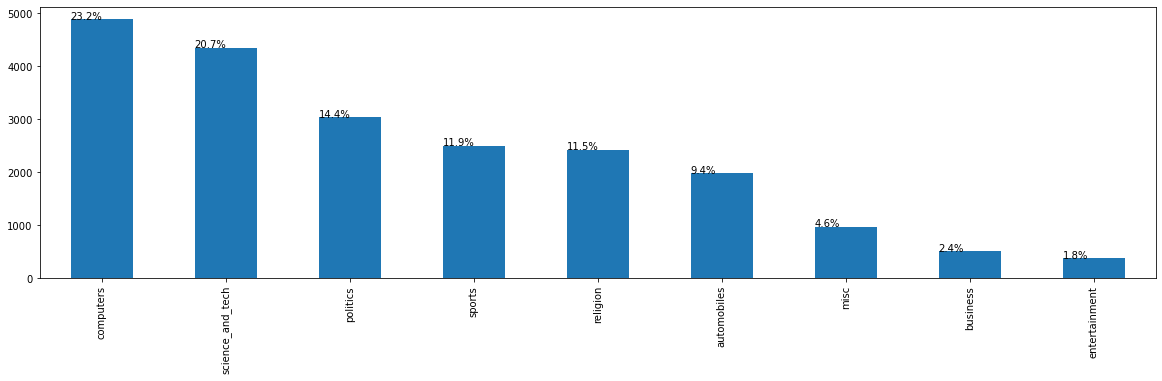

In [36]:
news_count = data['category'].value_counts()
news_percent = [len(data[data['category'] == news_cat]) / len(data) * 100 for news_cat in news_count.index]

ax = news_count.plot(kind='bar', figsize=(20, 5))
for idx, p in enumerate(ax.patches):
    h = p.get_height()
    x, y = p.get_xy()
    ax.annotate('{:.1f}%'.format(news_percent[idx]), (x, y + h + 0.01))

In [51]:
import re

from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
stop_words = set(stopwords.words("english"))

def cleanUpSentence(r, stop_words = stop_words):
    r = re.sub(strip_special_chars, " ", r.lower())
    r = re.sub('[0-9]+', ' ', r)
    if stop_words is not None:
        words = word_tokenize(r)
        filtered_sentence = []
        for w in words:
            w = lemmatizer.lemmatize(w)
            if ((w not in stop_words) and (len(w)<8) and (len(w)>2)):
                filtered_sentence.append(w)
        return " ".join(filtered_sentence)
    else:
        return r

In [52]:
#data["text"] = data["text"].apply(lambda x: cleanUpSentence(x))

In [53]:
#data.to_pickle("./data.pkl")
#data = pd.read_pickle("./data.pkl")

In [56]:
max_words = 20000
max_len = 125

In [57]:
from sklearn.model_selection import train_test_split
data = data.sample(frac = 1).reset_index(drop=True)
train_text, test_text, train_cat, test_cat = train_test_split(data['text'].values, data['category'].values, test_size=0.2)

In [58]:
max_words = 20000
OOV_TOK = '<OOV>'
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data["text"]) # fit tokenizer to our training text data

In [59]:
x_train = tokenizer.texts_to_sequences(train_text)
x_test = tokenizer.texts_to_sequences(test_text)

In [60]:
from keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

In [61]:
encoder = LabelEncoder()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (16842, 125)
x_test shape: (4211, 125)
y_train shape: (16842, 9)
y_test shape: (4211, 9)


# Embedding

In [62]:
vocab_size = len(tokenizer.word_index)+1

In [60]:
GLOVE_DIR = "C:/Users/bsooral/PycharmProjects/topicDetectFlask/glove.6B.300d.txt"
embeddings_index = {}
f = open(GLOVE_DIR,encoding="utf8")
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/bsooral/PycharmProjects/topicDetectFlask/glove.6B.300d.txt'

In [ ]:
embed_size = 300
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embed_size))
absent_words = 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1

# Modeling

In [63]:
from numpy import array
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.layers.embeddings import Embedding

In [64]:
vector_dim = 64
model = Sequential()
#model.add(Embedding(vocab_size, embed_size, weights=[embedding_matrix], input_length=max_len))
model.add(Embedding(vocab_size, vector_dim, input_length=max_len))
model.add(Bidirectional(LSTM(num_classes,activation="tanh",input_shape=(max_len, vector_dim), return_sequences = False)))
model.add(Dense(num_classes,activation="softmax"))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

print("Model Summary")
print(model.summary())

Model Summary
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 125, 64)           11839232  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 18)                5328      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 171       
Total params: 11,844,731
Trainable params: 11,844,731
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
history = model.fit(x_train, y_train, epochs=20, batch_size=256, validation_data=(x_test, y_test), verbose=1)

Train on 16842 samples, validate on 4211 samples
Epoch 1/20
16842/16842 [==============================] - 25s 1ms/step - loss: 0.3585 - accuracy: 0.9252 - val_loss: 0.6621 - val_accuracy: 0.8200
Epoch 2/20
16842/16842 [==============================] - 26s 2ms/step - loss: 0.3025 - accuracy: 0.9404 - val_loss: 0.6578 - val_accuracy: 0.8224
Epoch 3/20
16842/16842 [==============================] - 26s 2ms/step - loss: 0.2665 - accuracy: 0.9465 - val_loss: 0.6356 - val_accuracy: 0.8259
Epoch 4/20
16842/16842 [==============================] - 23s 1ms/step - loss: 0.2211 - accuracy: 0.9571 - val_loss: 0.6196 - val_accuracy: 0.8295
Epoch 5/20
16842/16842 [==============================] - 23s 1ms/step - loss: 0.1861 - accuracy: 0.9640 - val_loss: 0.5913 - val_accuracy: 0.8397
Epoch 6/20
16842/16842 [==============================] - 23s 1ms/step - loss: 0.1606 - accuracy: 0.9660 - val_loss: 0.6015 - val_accuracy: 0.8411
Epoch 7/20
16842/16842 [==============================] - 24s 1ms/ste

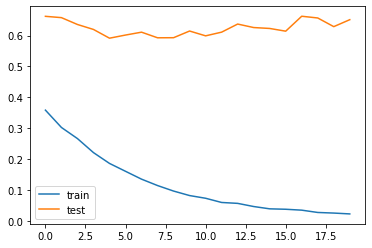

In [69]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [75]:
query = "As vote counting continues in key battleground states like Georgia and Pennsylvania, where Vice President Joe Biden has taken the lead over President Donald Trump on Friday, Libertarian presidential candidate Jo Jorgensen says third party candidates don’t “take” votes from other parties."
query = cleanUpSentence(query)
query = tokenizer.texts_to_sequences([query])
query = pad_sequences(query, maxlen=max_len, padding='post')
prediction = model.predict(np.array(query))
text_labels = encoder.classes_ 
text_labels[np.argmax(prediction)]

'politics'